In [1]:
import pandas as pd
import numpy as np
import os
from astropy.cosmology import Planck13
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

import disperse

from sklearn.neighbors import KDTree

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgbm

In [2]:
cosmo = Planck13
H0 = cosmo.H0.value
Om = cosmo.Om0
Ol = 0.69288
Ok = 0.0
print(f'H0 = {cosmo.H0.value}')
print(f'Om = {cosmo.Om0}')
print(f'Ol = {0.69288}')

H0 = 67.77
Om = 0.30712
Ol = 0.69288


In [3]:
np.random.seed(0)

In [4]:
gal_RA_int = (140, 260)
gal_DEC_int = (-10, 30)
gal_Z_int = (0, 1.0)

In [5]:
galaxies = pd.read_csv('SDSS/SDSS_DR16.csv')
galaxies = galaxies[galaxies['class'] == 'GALAXY']
galaxies = galaxies[(gal_RA_int[0] <= galaxies['ra']) & (galaxies['ra'] <= gal_RA_int[1])]
galaxies = galaxies[(gal_DEC_int[0] <= galaxies['dec']) & (galaxies['dec'] <= gal_DEC_int[1])]
galaxies = galaxies[(gal_Z_int[0] < galaxies['z']) & (galaxies['z'] <= gal_Z_int[1])]
galaxies = galaxies[['ra', 'dec', 'z']]
galaxies.columns = ['RA', 'DEC', 'Z']
galaxies.drop_duplicates(subset=['RA', 'DEC', 'Z'])
galaxies.reset_index(drop=True, inplace=True)

In [6]:
cl_RA_int = (160, 240)
cl_DEC_int = (0, 20)
cl_Z_int = (0, 1.0)

In [7]:
dat = Table.read('DR5_cluster-catalog_v1.1.fits', format='fits')
true_clusters = dat[['RADeg', 'decDeg', 'redshift', 'redshiftType', 'M500c']].to_pandas()
true_clusters = true_clusters[true_clusters['redshiftType'] == b'spec']
true_clusters = true_clusters[['RADeg', 'decDeg', 'redshift', 'M500c']]
true_clusters.columns = ['RA', 'DEC', 'Z', 'M']
true_clusters = true_clusters[(cl_RA_int[0] <= true_clusters['RA']) & (true_clusters['RA'] <= cl_RA_int[1])]
true_clusters = true_clusters[(cl_DEC_int[0] <= true_clusters['DEC']) & (true_clusters['DEC'] <= cl_DEC_int[1])]
true_clusters = true_clusters[(cl_Z_int[0] < true_clusters['Z']) & (true_clusters['Z'] <= cl_Z_int[1])]
true_clusters = true_clusters[['RA', 'DEC', 'Z', 'M']]
true_clusters.columns = ['RA', 'DEC', 'Z', 'M']
true_clusters.drop_duplicates(subset=['RA', 'DEC', 'Z', 'M'])
true_clusters = true_clusters.sort_values(by=['Z'])
true_clusters.reset_index(drop=True, inplace=True)
true_clusters['R'] = [0] * true_clusters.shape[0]
true_clusters['type'] = [1] * true_clusters.shape[0]
true_clusters

,RA,DEC,Z,M,R,type
0,230.761495,8.587807,0.035200,1.676978,0,1
1,230.452957,7.709549,0.044200,2.457475,0,1
2,227.733561,5.744353,0.076600,11.002140,0,1
3,208.253128,5.139146,0.078800,1.222567,0,1
4,173.207731,14.465334,0.083200,2.935207,0,1
...,...,...,...,...,...,...
514,190.801637,13.213381,0.789772,1.827705,0,1
515,160.265704,10.675110,0.789868,4.328044,0,1
516,199.909131,15.890405,0.796336,1.899555,0,1
517,211.772844,10.806421,0.836000,6.430338,0,1


In [8]:
util_DPS = disperse.Disperse3D(
    galaxies, '_disperse_03/bin/',
    H0, Om, Ol, Ok,
    clusters=true_clusters
)

In [9]:
#генерация случайных скоплений
RANDOM_CL_NUM = 3000
TRUE_R = 20
TRUE_CL_NUM = true_clusters.shape[0]

RA_int = (true_clusters['RA'].min(), true_clusters['RA'].max())
DEC_int = (true_clusters['DEC'].min(), true_clusters['DEC'].max())
Z_int = (true_clusters['Z'].min(), np.quantile(true_clusters['Z'], [1])[0])

CX, CY, CZ = util_DPS.sph2cart(
    true_clusters['RA'], true_clusters['DEC'], true_clusters['Z']
)
points = [[CX[i], CY[i], CZ[i]] for i in range(true_clusters.shape[0])]
kd_tree = KDTree(points, leaf_size=2)

not_generate = RANDOM_CL_NUM
RA, DEC, Z = np.array([]), np.array([]), np.array([])
while not_generate > 0:
    print('###')
    RA_ = np.random.uniform(RA_int[0], RA_int[1], not_generate)
    DEC_ = np.random.uniform(DEC_int[0], DEC_int[1], not_generate)
    Z_ = np.random.uniform(Z_int[0], Z_int[1], not_generate)
    CX, CY, CZ = util_DPS.sph2cart(RA_, DEC_, Z_)
    points = [[CX[i], CY[i], CZ[i]] for i in range(not_generate)]
    inters = kd_tree.query_radius(points, TRUE_R, count_only=True)
    RA = np.concatenate((RA, RA_[inters==0]))
    DEC = np.concatenate((DEC, DEC_[inters==0]))
    Z = np.concatenate((Z, Z_[inters==0]))
    not_generate = RANDOM_CL_NUM - len(RA)
    
M = [0] * RANDOM_CL_NUM
R = [0] * RANDOM_CL_NUM
type_ = [0] * RANDOM_CL_NUM

false_clusters = pd.DataFrame({
    'RA': RA, 'DEC': DEC, 'Z': Z, 'M': M, 'R': R, 'type': type_
})
false_clusters = false_clusters.sort_values(by=['Z'])
false_clusters.reset_index(drop=True, inplace=True)
false_clusters

###
###


,RA,DEC,Z,M,R,type
0,224.318170,18.298528,0.035341,0,0,0
1,225.297974,15.696523,0.035439,0,0,0
2,209.366065,4.278488,0.035488,0,0,0
3,175.718640,10.741538,0.035883,0,0,0
4,185.454467,14.964984,0.036000,0,0,0
...,...,...,...,...,...,...
2995,223.945763,13.575658,0.973103,0,0,0
2996,208.112124,12.704961,0.974156,0,0,0
2997,225.595953,15.674643,0.974510,0,0,0
2998,208.626549,6.281232,0.974726,0,0,0


In [10]:
clusters = pd.concat((true_clusters, false_clusters), axis=0)
clusters.reset_index(drop=True, inplace=True)
clusters

,RA,DEC,Z,M,R,type
0,230.761495,8.587807,0.035200,1.676978,0,1
1,230.452957,7.709549,0.044200,2.457475,0,1
2,227.733561,5.744353,0.076600,11.002140,0,1
3,208.253128,5.139146,0.078800,1.222567,0,1
4,173.207731,14.465334,0.083200,2.935207,0,1
...,...,...,...,...,...,...
3514,223.945763,13.575658,0.973103,0.000000,0,0
3515,208.112124,12.704961,0.974156,0.000000,0,0
3516,225.595953,15.674643,0.974510,0.000000,0,0
3517,208.626549,6.281232,0.974726,0.000000,0,0


In [11]:
CX, CY, CZ = util_DPS.sph2cart(clusters['RA'], clusters['DEC'], clusters['Z'])
clusters['CX'] = CX
clusters['CY'] = CY
clusters['CZ'] = CZ
clusters

,RA,DEC,Z,M,R,type,CX,CY,CZ
0,230.761495,8.587807,0.035200,1.676978,0,1,-96.597031,-118.277283,23.062053
1,230.452957,7.709549,0.044200,2.457475,0,1,-122.101803,-147.873793,25.960786
2,227.733561,5.744353,0.076600,11.002140,0,1,-222.703294,-245.035914,33.308899
3,208.253128,5.139146,0.078800,1.222567,0,1,-300.190348,-161.319215,30.649445
4,173.207731,14.465334,0.083200,2.935207,0,1,-346.994931,41.329156,90.147741
...,...,...,...,...,...,...,...,...,...
3514,223.945763,13.575658,0.973103,0.000000,0,0,-2331.074870,-2246.832330,781.806185
3515,208.112124,12.704961,0.974156,0.000000,0,0,-2868.107915,-1532.207054,733.103239
3516,225.595953,15.674643,0.974510,0.000000,0,0,-2246.247683,-2293.468507,900.824358
3517,208.626549,6.281232,0.974726,0.000000,0,0,-2909.568304,-1588.097526,364.854029


In [12]:
idx = np.concatenate(
    (
        np.random.choice(
            list(range(true_clusters.shape[0])), size=true_clusters.shape[0] // 2, replace=False
        ),
        np.random.choice(
            list(range(false_clusters.shape[0])), size=false_clusters.shape[0] // 2, replace=False
        ) + true_clusters.shape[0]
    )
)
mask = np.array([False] * clusters.shape[0])
mask[idx] = True
mask

array([ True,  True,  True, ..., False,  True, False])

In [13]:
clusters_1 = clusters.loc[mask].reset_index(drop=True)

In [14]:
clusters_2 = clusters.loc[~mask].reset_index(drop=True)

In [15]:
clusters_1

,RA,DEC,Z,M,R,type,CX,CY,CZ
0,230.761495,8.587807,0.035200,1.676978,0,1,-96.597031,-118.277283,23.062053
1,230.452957,7.709549,0.044200,2.457475,0,1,-122.101803,-147.873793,25.960786
2,227.733561,5.744353,0.076600,11.002140,0,1,-222.703294,-245.035914,33.308899
3,173.207731,14.465334,0.083200,2.935207,0,1,-346.994931,41.329156,90.147741
4,197.227702,10.482027,0.086600,1.447222,0,1,-352.505669,-109.305524,68.282153
...,...,...,...,...,...,...,...,...,...
1754,197.783537,11.902833,0.971918,0.000000,0,0,-3100.534572,-994.490136,686.340490
1755,187.696528,2.947634,0.972448,0.000000,0,0,-3294.658874,-445.252076,171.188641
1756,193.536598,7.967492,0.972497,0.000000,0,0,-3205.411934,-771.717146,461.455815
1757,173.232745,17.119484,0.972844,0.000000,0,0,-3160.301730,375.011448,980.241633


In [16]:
clusters_2

,RA,DEC,Z,M,R,type,CX,CY,CZ
0,208.253128,5.139146,0.078800,1.222567,0,1,-300.190348,-161.319215,30.649445
1,163.466549,16.844133,0.085400,2.420530,0,1,-339.698430,100.839024,107.282298
2,186.872422,8.826783,0.089300,1.392481,0,1,-379.449091,-45.733082,59.349887
3,214.894451,6.794426,0.114086,1.213342,0,1,-400.015147,-278.996844,58.106596
4,229.079233,0.087499,0.117890,2.515684,0,1,-332.126098,-383.136158,0.774345
...,...,...,...,...,...,...,...,...,...
1755,233.657284,0.869823,0.972945,0.000000,0,0,-1973.338312,-2682.181224,50.555825
1756,223.945763,13.575658,0.973103,0.000000,0,0,-2331.074870,-2246.832330,781.806185
1757,208.112124,12.704961,0.974156,0.000000,0,0,-2868.107915,-1532.207054,733.103239
1758,225.595953,15.674643,0.974510,0.000000,0,0,-2246.247683,-2293.468507,900.824358


In [17]:
sigmas = [round(i, 1) for i in np.arange(0.2, 14.2, 0.2)]

In [18]:
f_name = 'ACT_04_01_dists.npy'
if os.path.exists(f_name):
    with open(f_name, 'rb') as f:
        dists = np.load(f)
else:
    dists = []
    for sigma in tqdm(sigmas):
        DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')

        _, _, cl_dists \
            = DPS.count_conn(clusters_1['R'], clusters_1)
        dists.append(np.array(cl_dists)[None,:])
    dists = np.concatenate(dists, axis=0)
    dists = dists.T
    with open(f_name, 'wb') as f:
        np.save(f, dists)
    
dists_1 = dists
print(dists_1.shape)

#==================================================================

f_name = 'ACT_04_02_dists.npy'
if os.path.exists(f_name):
    with open(f_name, 'rb') as f:
        dists = np.load(f)
else:
    dists = []
    for sigma in tqdm(sigmas):
        DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')

        _, _, cl_dists \
            = DPS.count_conn(clusters_2['R'], clusters_2)
        dists.append(np.array(cl_dists)[None,:])
    dists = np.concatenate(dists, axis=0)
    dists = dists.T
    with open(f_name, 'wb') as f:
        np.save(f, dists)
    
dists_2 = dists
print(dists_2.shape)

(1759, 70)
(1760, 70)


In [19]:
X_1 = np.concatenate((dists_1, clusters_1['Z'].values.reshape(-1, 1)), axis=1)
Y_1 = clusters_1['type'].values
X_1.shape, Y_1.shape

((1759, 71), (1759,))

In [20]:
X_2 = np.concatenate((dists_2, clusters_2['Z'].values.reshape(-1, 1)), axis=1)
Y_2 = clusters_2['type'].values
X_2.shape, Y_2.shape

((1760, 71), (1760,))

In [21]:
rf_1 = RandomForestClassifier(
    max_depth=10, 
    random_state=0,
    n_estimators=500,
    max_features=None
).fit(X_1, Y_1)

rf_scores_2 = rf_1.predict_proba(X_2)[:,1].reshape(-1)
roc_auc_score(Y_2, rf_scores_2)

0.8787820512820514

In [22]:
rf_2 = RandomForestClassifier(
    max_depth=10, 
    random_state=0,
    n_estimators=500,
    max_features=None
).fit(X_2, Y_2)

rf_scores_1 = rf_2.predict_proba(X_1)[:,1].reshape(-1)
roc_auc_score(Y_1, rf_scores_1)

0.9074054054054055

In [23]:
t1 = clusters_1[clusters_1['type'] == 1]
t2 = clusters_1[clusters_1['type'] == 0]
t2 = t2.iloc[list(range(0, t2.shape[0], t2.shape[0] // t1.shape[0]))]
clusters_1_test = pd.concat((t1, t2), axis=0).reset_index(drop=True)
clusters_1_test['ID'] = list(range(clusters_1_test.shape[0]))

t1 = clusters_2[clusters_2['type'] == 1]
t2 = clusters_2[clusters_2['type'] == 0]
t2 = t2.iloc[list(range(0, t2.shape[0], t2.shape[0] // t1.shape[0]))]
clusters_2_test = pd.concat((t1, t2), axis=0).reset_index(drop=True)
clusters_2_test['ID'] = list(range(clusters_2_test.shape[0]))

In [24]:
clusters_1_test

,RA,DEC,Z,M,R,type,CX,CY,CZ,ID
0,230.761495,8.587807,0.035200,1.676978,0,1,-96.597031,-118.277283,23.062053,0
1,230.452957,7.709549,0.044200,2.457475,0,1,-122.101803,-147.873793,25.960786,1
2,227.733561,5.744353,0.076600,11.002140,0,1,-222.703294,-245.035914,33.308899,2
3,173.207731,14.465334,0.083200,2.935207,0,1,-346.994931,41.329156,90.147741,3
4,197.227702,10.482027,0.086600,1.447222,0,1,-352.505669,-109.305524,68.282153,4
...,...,...,...,...,...,...,...,...,...,...
554,162.915908,1.876666,0.958379,0.000000,0,0,-3146.224039,966.948763,107.847073,554
555,236.991615,10.469757,0.961539,0.000000,0,0,-1768.474971,-2722.340320,599.898950,555
556,219.839721,17.195199,0.965044,0.000000,0,0,-2428.108674,-2025.877337,978.592735,556
557,180.191054,9.332654,0.968315,0.000000,0,0,-3274.588626,-10.919233,538.153894,557


In [25]:
clusters_2_test

,RA,DEC,Z,M,R,type,CX,CY,CZ,ID
0,208.253128,5.139146,0.078800,1.222567,0,1,-300.190348,-161.319215,30.649445,0
1,163.466549,16.844133,0.085400,2.420530,0,1,-339.698430,100.839024,107.282298,1
2,186.872422,8.826783,0.089300,1.392481,0,1,-379.449091,-45.733082,59.349887,2
3,214.894451,6.794426,0.114086,1.213342,0,1,-400.015147,-278.996844,58.106596,3
4,229.079233,0.087499,0.117890,2.515684,0,1,-332.126098,-383.136158,0.774345,4
...,...,...,...,...,...,...,...,...,...,...
555,224.096347,0.166965,0.958732,0.000000,0,0,-2365.736762,-2292.265917,9.599349,555
556,209.251637,11.967993,0.963625,0.000000,0,0,-2822.246337,-1580.639825,685.675262,556
557,175.081947,11.903745,0.966985,0.000000,0,0,-3231.918622,278.098989,683.810275,557
558,225.013898,7.416451,0.970253,0.000000,0,0,-2329.808542,-2330.939047,428.991955,558


In [26]:
z = [round(i, 4) for i in np.arange(0.002, 1.0, 0.002)]

ID, RA, DEC, Z, Z_true, M, R, TYPE = [], [], [], [], [], [], [], []
for i in range(clusters_1_test.shape[0]):
    row = clusters_1_test.iloc[i]
    ID = ID + [int(row['ID'])] * len(z)
    RA = RA + [row['RA']] * len(z)
    DEC = DEC + [row['DEC']] * len(z)
    Z = Z + z.copy()
    Z_true = Z_true + [row['Z']] * len(z)
    TYPE = TYPE + [int(row['type'])] * len(z)
    M = M + [row['M']] * len(z)
    R = R + [row['R']] * len(z)
CX, CY, CZ = util_DPS.sph2cart(RA, DEC, Z)
clusters_1_test_ext = pd.DataFrame({
    'ID': ID, 'RA': RA, 'DEC': DEC, 'Z': Z,
    'CX': CX, 'CY': CY, 'CZ': CZ,
    'Z_true': Z_true, 'M': M, 'R': R, 'type': TYPE
})

ID, RA, DEC, Z, Z_true, M, R, TYPE = [], [], [], [], [], [], [], []
for i in range(clusters_2_test.shape[0]):
    row = clusters_2_test.iloc[i]
    ID = ID + [int(row['ID'])] * len(z)
    RA = RA + [row['RA']] * len(z)
    DEC = DEC + [row['DEC']] * len(z)
    Z = Z + z.copy()
    Z_true = Z_true + [row['Z']] * len(z)
    TYPE = TYPE + [int(row['type'])] * len(z)
    M = M + [row['M']] * len(z)
    R = R + [row['R']] * len(z)
CX, CY, CZ = util_DPS.sph2cart(RA, DEC, Z)
clusters_2_test_ext = pd.DataFrame({
    'ID': ID, 'RA': RA, 'DEC': DEC, 'Z': Z,
    'CX': CX, 'CY': CY, 'CZ': CZ,
    'Z_true': Z_true, 'M': M, 'R': R, 'type': TYPE
})

In [27]:
clusters_1_test_ext

,ID,RA,DEC,Z,CX,CY,CZ,Z_true,M,R,type
0,0,230.761495,8.587807,0.002,-5.531095,-6.772495,1.320521,0.035200,1.676978,0.0,1
1,0,230.761495,8.587807,0.004,-11.057085,-13.538739,2.639823,0.035200,1.676978,0.0,1
2,0,230.761495,8.587807,0.006,-16.577964,-20.298725,3.957905,0.035200,1.676978,0.0,1
3,0,230.761495,8.587807,0.008,-22.093726,-27.052446,5.274765,0.035200,1.676978,0.0,1
4,0,230.761495,8.587807,0.010,-27.604365,-33.799893,6.590403,0.035200,1.676978,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
278936,558,197.783537,11.902833,0.990,-3143.000409,-1008.110966,695.740812,0.971918,0.000000,0.0,0
278937,558,197.783537,11.902833,0.992,-3147.669730,-1009.608641,696.774422,0.971918,0.000000,0.0,0
278938,558,197.783537,11.902833,0.994,-3152.333583,-1011.104563,697.806822,0.971918,0.000000,0.0,0
278939,558,197.783537,11.902833,0.996,-3156.991976,-1012.598733,698.838013,0.971918,0.000000,0.0,0


In [28]:
clusters_2_test_ext

,ID,RA,DEC,Z,CX,CY,CZ,Z_true,M,R,type
0,0,208.253128,5.139146,0.002,-7.758414,-4.169292,0.792134,0.078800,1.222567,0.0,1
1,0,208.253128,5.139146,0.004,-15.509669,-8.334737,1.583538,0.078800,1.222567,0.0,1
2,0,208.253128,5.139146,0.006,-23.253754,-12.496329,2.374209,0.078800,1.222567,0.0,1
3,0,208.253128,5.139146,0.008,-30.990661,-16.654063,3.164148,0.078800,1.222567,0.0,1
4,0,208.253128,5.139146,0.010,-38.720382,-20.807936,3.953352,0.078800,1.222567,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
279435,559,233.657284,0.869823,0.990,-1998.802490,-2716.792391,51.208203,0.972945,0.000000,0.0,0
279436,559,233.657284,0.869823,0.992,-2001.771961,-2720.828526,51.284279,0.972945,0.000000,0.0,0
279437,559,233.657284,0.869823,0.994,-2004.737955,-2724.859935,51.360266,0.972945,0.000000,0.0,0
279438,559,233.657284,0.869823,0.996,-2007.700478,-2728.886625,51.436165,0.972945,0.000000,0.0,0


In [29]:
f_name = 'ACT_04_01_dists_test_ext.npy'
if os.path.exists(f_name):
    with open(f_name, 'rb') as f:
        dists = np.load(f)
else:
    dists = []
    for sigma in tqdm(sigmas):
        DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')

        _, _, cl_dists \
            = DPS.count_conn(clusters_1_test_ext['R'], clusters_1_test_ext)
        dists.append(np.array(cl_dists)[None,:])
    dists = np.concatenate(dists, axis=0)
    dists = dists.T
    with open(f_name, 'wb') as f:
        np.save(f, dists)
    
dists_1_test_ext = dists
print(dists_1_test_ext.shape)

#==================================================================

f_name = 'ACT_04_02_dists_test_ext.npy'
if os.path.exists(f_name):
    with open(f_name, 'rb') as f:
        dists = np.load(f)
else:
    dists = []
    for sigma in tqdm(sigmas):
        DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')

        _, _, cl_dists \
            = DPS.count_conn(clusters_2_test_ext['R'], clusters_2_test_ext)
        dists.append(np.array(cl_dists)[None,:])
    dists = np.concatenate(dists, axis=0)
    dists = dists.T
    with open(f_name, 'wb') as f:
        np.save(f, dists)
    
dists_2_test_ext = dists
print(dists_2_test_ext.shape)

(278941, 70)
(279440, 70)


In [30]:
X_1_test_ext = np.concatenate(
    (dists_1_test_ext, clusters_1_test_ext['Z'].values.reshape(-1, 1)),
    axis=1
)
rf_scores_1_test_ext = rf_2.predict_proba(X_1_test_ext)[:,1].reshape(-1)
rf_scores_1_test_ext.shape

(278941,)

In [31]:
X_2_test_ext = np.concatenate(
    (dists_2_test_ext, clusters_2_test_ext['Z'].values.reshape(-1, 1)),
    axis=1
)
rf_scores_2_test_ext = rf_1.predict_proba(X_2_test_ext)[:,1].reshape(-1)
rf_scores_2_test_ext.shape

(279440,)

In [32]:
clusters_1_test_ext['rf_score'] = rf_scores_1_test_ext
clusters_2_test_ext['rf_score'] = rf_scores_2_test_ext

In [33]:
clusters_1_test_ext

,ID,RA,DEC,Z,CX,CY,CZ,Z_true,M,R,type,rf_score
0,0,230.761495,8.587807,0.002,-5.531095,-6.772495,1.320521,0.035200,1.676978,0.0,1,0.178000
1,0,230.761495,8.587807,0.004,-11.057085,-13.538739,2.639823,0.035200,1.676978,0.0,1,0.574000
2,0,230.761495,8.587807,0.006,-16.577964,-20.298725,3.957905,0.035200,1.676978,0.0,1,0.728000
3,0,230.761495,8.587807,0.008,-22.093726,-27.052446,5.274765,0.035200,1.676978,0.0,1,0.038102
4,0,230.761495,8.587807,0.010,-27.604365,-33.799893,6.590403,0.035200,1.676978,0.0,1,0.012000
...,...,...,...,...,...,...,...,...,...,...,...,...
278936,558,197.783537,11.902833,0.990,-3143.000409,-1008.110966,695.740812,0.971918,0.000000,0.0,0,0.003664
278937,558,197.783537,11.902833,0.992,-3147.669730,-1009.608641,696.774422,0.971918,0.000000,0.0,0,0.001725
278938,558,197.783537,11.902833,0.994,-3152.333583,-1011.104563,697.806822,0.971918,0.000000,0.0,0,0.001725
278939,558,197.783537,11.902833,0.996,-3156.991976,-1012.598733,698.838013,0.971918,0.000000,0.0,0,0.001725


In [34]:
clusters_2_test_ext

,ID,RA,DEC,Z,CX,CY,CZ,Z_true,M,R,type,rf_score
0,0,208.253128,5.139146,0.002,-7.758414,-4.169292,0.792134,0.078800,1.222567,0.0,1,0.024000
1,0,208.253128,5.139146,0.004,-15.509669,-8.334737,1.583538,0.078800,1.222567,0.0,1,0.474000
2,0,208.253128,5.139146,0.006,-23.253754,-12.496329,2.374209,0.078800,1.222567,0.0,1,0.000000
3,0,208.253128,5.139146,0.008,-30.990661,-16.654063,3.164148,0.078800,1.222567,0.0,1,0.002000
4,0,208.253128,5.139146,0.010,-38.720382,-20.807936,3.953352,0.078800,1.222567,0.0,1,0.002000
...,...,...,...,...,...,...,...,...,...,...,...,...
279435,559,233.657284,0.869823,0.990,-1998.802490,-2716.792391,51.208203,0.972945,0.000000,0.0,0,0.532316
279436,559,233.657284,0.869823,0.992,-2001.771961,-2720.828526,51.284279,0.972945,0.000000,0.0,0,0.534816
279437,559,233.657284,0.869823,0.994,-2004.737955,-2724.859935,51.360266,0.972945,0.000000,0.0,0,0.534816
279438,559,233.657284,0.869823,0.996,-2007.700478,-2728.886625,51.436165,0.972945,0.000000,0.0,0,0.578816


In [35]:
Z_pred = []
max_scores = []
for ID in range(clusters_1_test['ID'].max()+1):
    scores = clusters_1_test_ext[clusters_1_test_ext['ID'] == ID]['rf_score'].values
    Z_pred.append(z[scores.argmax()])
    max_scores.append(scores.max())
clusters_1_test['Z_pred'] = Z_pred
clusters_1_test['max_score'] = max_scores

Z_pred = []
max_scores = []
for ID in range(clusters_2_test['ID'].max()+1):
    scores = clusters_2_test_ext[clusters_2_test_ext['ID'] == ID]['rf_score'].values
    Z_pred.append(z[scores.argmax()])
    max_scores.append(scores.max())
clusters_2_test['Z_pred'] = Z_pred
clusters_2_test['max_score'] = max_scores

clusters_test = pd.concat((clusters_1_test, clusters_2_test), axis=0)
clusters_test.sort_values(by=['type'], ascending=False, inplace=True)
clusters_test

,RA,DEC,Z,M,R,type,CX,CY,CZ,ID,Z_pred,max_score
0,230.761495,8.587807,0.035200,1.676978,0,1,-96.597031,-118.277283,23.062053,0,0.472,0.906539
97,208.607874,19.544846,0.359767,2.600216,0,1,-1202.972199,-656.096219,486.440800,97,0.354,0.896695
95,238.755974,18.678286,0.358603,2.810605,0,1,-712.374615,-1174.233085,464.299238,95,0.564,0.923472
94,200.989039,18.169481,0.357989,1.592576,0,1,-1284.105906,-492.640237,451.384579,94,0.358,1.000000
93,188.425000,2.979215,0.357658,1.694388,0,1,-1428.784026,-211.621529,75.170872,93,0.252,0.996000
...,...,...,...,...,...,...,...,...,...,...,...,...
463,196.593114,14.243450,0.659696,0.000000,0,0,-2283.359004,-680.400105,604.807499,463,0.184,0.967871
464,209.719630,5.554086,0.661863,0.000000,0,0,-2130.497946,-1216.182174,238.552369,464,0.522,0.820189
465,214.630456,7.848270,0.665098,0.000000,0,0,-2017.127038,-1393.105815,337.909393,465,0.238,0.947571
466,174.843093,5.537745,0.671046,0.000000,0,0,-2471.017991,223.006522,240.548667,466,0.462,0.987379


In [36]:
roc_auc_score(clusters_test['type'], clusters_test['max_score'])

0.5895696852922286

0.5895696852922286

In [45]:
clusters_test[(clusters_test['type'] == 1) & (clusters_test['M'] > 5)]

,RA,DEC,Z,M,R,type,CX,CY,CZ,ID,Z_pred,max_score
91,168.964709,1.499083,0.355668,6.955418,0,1,-1411.950463,275.358008,37.646714,91,0.356,0.891740
11,187.693803,10.558505,0.167168,5.480988,0,1,-691.932995,-93.476807,130.144754,11,0.466,0.915947
202,174.231486,0.100596,0.587188,5.669064,0,1,-2220.406327,224.307936,3.918301,202,0.826,0.938000
259,211.772844,10.806421,0.836000,6.430338,0,1,-2479.343209,-1535.631547,556.669132,259,0.514,0.990000
250,197.850428,18.703500,0.752108,5.883814,0,1,-2463.783598,-793.427065,876.297481,250,0.450,0.985556
2,227.733561,5.744353,0.076600,11.002140,0,1,-222.703294,-245.035914,33.308899,2,0.080,0.882000
33,210.257769,2.875714,0.251788,10.814374,0,1,-903.150648,-526.866010,52.523230,33,0.572,0.969913
83,221.859776,8.472512,0.375000,6.650990,0,1,-1111.952050,-996.289305,222.397162,83,0.376,0.993965


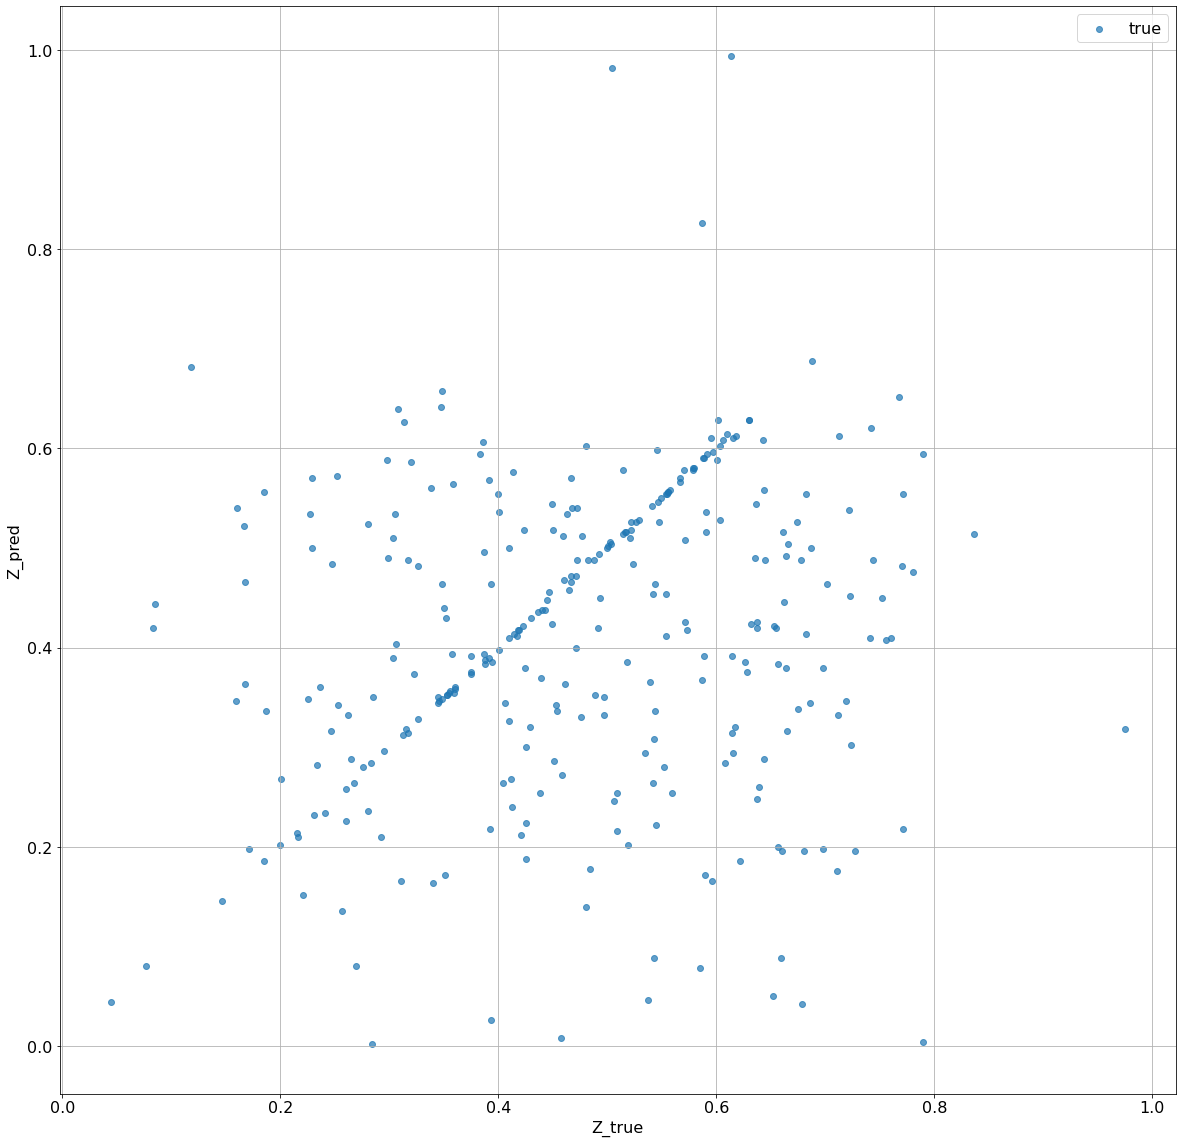

In [48]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 20))
plt.grid()

# plt.scatter(
#     clusters_test[clusters_test['type'] == 1]['Z'],
#     clusters_test[clusters_test['type'] == 1]['Z_pred'],
#     label='true',
#     alpha=0.7
# )

plt.scatter(
    clusters_test[(clusters_test['type'] == 1) & (clusters_test['M'] > 2)]['Z'],
    clusters_test[(clusters_test['type'] == 1) & (clusters_test['M'] > 2)]['Z_pred'],
    label='true',
    alpha=0.7
)

# plt.scatter(
#     clusters_test[clusters_test['type'] == 0]['Z'],
#     clusters_test[clusters_test['type'] == 0]['Z_pred'],
#     label='false',
#     alpha=0.7
# )

plt.xlabel('Z_true')
plt.ylabel('Z_pred')
plt.legend()

In [41]:
np.abs(clusters_test[clusters_test['type'] == 1]['Z'] - clusters_test[clusters_test['type'] == 1]['Z_pred']).mean()

0.149549063927213

In [42]:
np.abs(clusters_test[clusters_test['type'] == 0]['Z'] - clusters_test[clusters_test['type'] == 0]['Z_pred']).mean()

0.2784609891519173

In [38]:
# font = {'size': 16}
# plt.rc('font', **font)
# fig = plt.figure(figsize=(20, 12))
# plt.ylim(0, 1)
# plt.grid()

# ID = 300

# plt.plot(
#     clusters_1_test_ext[clusters_1_test_ext['ID'] == ID]['Z'][:],
#     clusters_1_test_ext[clusters_1_test_ext['ID'] == ID]['rf_score'][:],
#     alpha=0.5,
#     label='rf_score'
# )

# plt.plot(
#     clusters_1_test_ext[clusters_1_test_ext['ID'] == ID]['Z_true'].iloc[0], 
#     1, 'ro', markersize=12
# )
# plt.vlines(
#     clusters_1_test_ext[clusters_1_test_ext['ID'] == ID]['Z_true'].iloc[0],
#     0, 1, colors='r', linestyles='--', linewidth=1, alpha=0.3
# )

# plt.xlabel('Z')
# plt.ylabel('score')
# plt.legend()